In [7]:
#@title
#HIDDEN
from IPython.display import display, clear_output
import numpy as np
import numpy.ma as ma
import matplotlib as mpl
import matplotlib.pyplot as plt
from ipywidgets import interactive, widgets
from mpl_toolkits.axisartist import SubplotZero
from IPython.display import YouTubeVideo
from matplotlib.patches import Ellipse, Rectangle, Arc
from matplotlib.ticker import FormatStrFormatter
from matplotlib import patches
from scipy import stats
mpl.rc('font', **{'family': 'serif', 'serif':['Computer Modern'], 'size': 14})
mpl.rc('text', usetex=True)

%config InlineBackend.figure_formats = ['svg']
%matplotlib inline

In [2]:
#HIDDEN
def arrowed_spines(fig, ax, w_scl=40, l_scl=40, xlim=None, ylim=None):
    '''
    Solution provided in 
    https://stackoverflow.com/questions/33737736/matplotlib-axis-arrow-tip
    '''
    if xlim==None:
        xmin, xmax = ax.get_xlim()
    else:
        xmin, xmax = xlim
    if ylim==None:
        ymin, ymax = ax.get_ylim()
    else:
        ymin, ymax = ylim
    # removing the default axis on all sides:
    for side in ['bottom','right','top','left']:
        ax.spines[side].set_visible(False)

    # removing the axis ticks
    ax.set_xticks([]) # labels 
    ax.set_yticks([])
    ax.xaxis.set_ticks_position('none') # tick markers
    ax.yaxis.set_ticks_position('none')

    # get width and height of axes object to compute 
    # matching arrowhead length and width
    dps = fig.dpi_scale_trans.inverted()
    bbox = ax.get_window_extent().transformed(dps)
    width, height = bbox.width, bbox.height

    # manual arrowhead width and length
    hw = 1./w_scl*(ymax-ymin) 
    hl = 1./l_scl*(xmax-xmin)
    lw = 1. # axis line width
    ohg = 0 # arrow overhang

    # compute matching arrowhead length and width
    yhw = hw/(ymax-ymin)*(xmax-xmin)* height/width 
    yhl = hl/(xmax-xmin)*(ymax-ymin)* width/height

    # draw x and y axis
    ax.arrow(xmin, 0, xmax-xmin, 0., fc='k', ec='k', lw = lw, 
             head_width=hw, head_length=hl, overhang = ohg, 
             length_includes_head= True, clip_on = False) 

    ax.arrow(0, ymin, 0., ymax-ymin, fc='k', ec='k', lw = lw, 
             head_width=yhw, head_length=yhl, overhang = ohg, 
             length_includes_head= True, clip_on = False)
    
def add_interval(ax, xdata, ydata, caps="  "):
    line = ax.add_line(mpl.lines.Line2D(xdata, ydata, zorder=12, c='k'))
    anno_args = {
        'ha': 'center',
        'va': 'center',
        'size': 16,
        'color': line.get_color()
    }
    a0 = ax.annotate(caps[0], xy=(xdata[0], ydata[0]), zorder=12, **anno_args)
    a1 = ax.annotate(caps[1], xy=(xdata[1], ydata[1]), zorder=12, **anno_args)
    return (line,(a0,a1))

def plot_arrow(ax, theta):
    x_0 = 0
    y_0 = 0
    if theta >= 0:
        y_1 = 0.1
    else:
        y_1 = -0.1
    if theta !=0:
        x_1 = y_1/np.tan(theta)
    else:
        x_1 = y_1/np.tan(1e-8)
    x_h_1 = x_1/np.linalg.norm([x_1, y_1])
    y_h_1 = y_1/np.linalg.norm([x_1, y_1])
    ax.quiver(x_0, y_0, x_h_1*0.75, y_h_1*0.75, units='xy', scale=1, color='gray', label='Direction of Propagation')
    ax.add_patch(Arc([x_0, y_0], 0.5, y_h_1/2, theta1=0, theta2=np.degrees(np.arctan(y_h_1/x_h_1)), color='gray', lw=2))
    props = dict(boxstyle='round', facecolor='white', alpha=0.75)
    ax.text(x_h_1*0.25+0.1, y_h_1*0.25+0.01, r'$\theta$', c='k', bbox=props)

    ax.set_aspect('equal')
    ax.set_xlim(-1.2, 1.2)
    ax.set_ylim(-1.2, 1.2)
    
def create_multipleChoice_widget(description, options, correct_answer):
    if correct_answer not in options:
        options.append(correct_answer)
    
    correct_answer_index = options.index(correct_answer)
    
    radio_options = [(words, i) for i, words in enumerate(options)]
    alternativ = widgets.RadioButtons(
        options = radio_options,
        description = '',
        disabled = False
    )
    
    description_out = widgets.HTMLMath(description)
        
    feedback_out = widgets.Output()

    def check_selection(b):
        a = int(alternativ.value)
        if a==correct_answer_index:
            s = '\x1b[6;30;42m' + " Congratulations! You're right! " + '\x1b[0m' +"\n" #green color
        else:
            s = '\x1b[5;30;41m' + " Wrong Anwser! Try again!" + '\x1b[0m' +"\n" #red color
        with feedback_out:
            clear_output()
            print(s)
        return
    
    check = widgets.Button(description="Submit!")
    check.on_click(check_selection)
    
    
    return widgets.VBox([description_out, alternativ, check, feedback_out])


def sbs(texts):
    btn_next = widgets.Button(description='Next')
    btn_back = widgets.Button(description='Back')
    btn_back.disabled = True
    texts_disps = []
    total_texts = len(texts)
    for text in texts:
        texts_disps.append(widgets.HTMLMath(text))
    for text_disp in texts_disps:
        text_disp.layout = widgets.Layout(display='none')

    global i_vis 
    i_vis = 0

    def update_vis(i_vis):
        if i_vis == total_texts:
            btn_next.disabled = True
        else:
            btn_next.disabled = False
        if i_vis != 0:
            btn_back.disabled = False
        else:
            btn_back.disabled = True

        for text_disp in texts_disps:
            text_disp.layout = widgets.Layout(display='none')
        for i in range(i_vis):
            try:
                texts_disps[i].layout.display = 'block'
            except:
                pass
    
    def clicked_btn_next(btn_object):
        global i_vis
        i_vis += 1
        update_vis(i_vis)
        
    def clicked_btn_back(btn_object):
        global i_vis
        i_vis -= 1
        update_vis(i_vis)
    
    btn_next.on_click(clicked_btn_next)
    btn_back.on_click(clicked_btn_back)
    bts = widgets.HBox([btn_back, btn_next])
    out = widgets.VBox(texts_disps + [bts], layout=widgets.Layout(width='100%', display='column-flex'))
    return out

# Quick Review

In [Lesson 1](https://murilohmoreira.github.io/host_widgets/lesson_1.html) we found that the tip of the defect acts as a stress raiser because of the concentration of force lines around it, and as shown below, the geometry of the defect influences how much this effect occurs:

In [3]:
#HIDDEN

def circle(C, R):
    t=np.linspace(0,2*np.pi, 200)
    return C+R*np.exp(1j*t)
def Juc(z, lam):#Joukowski transformation
    return z+(lam**2)/z

def deg2radians(deg):
    return deg*np.pi/180

def compute_lines(rho):
    '''
    Based on the Joukowski transformation of the potential flow past a cylinder.
    For reference:
    https://people.eng.unimelb.edu.au/asho/PotentialFlow/notes.pdf
    https://github.com/luca6331/joukowskiAirfoilVisualization/blob/master/Report.pdf
    https://nbviewer.jupyter.org/github/empet/Math/blob/master/Joukowski-airfoil.ipynb
    
    '''

    V_inf = 1
    R = 1
    lam = (R**2 + R*rho/2 - R*(8*R*rho + rho**2)**0.5/2)**0.5
    alpha=deg2radians(0) # angle of attack
    beta=deg2radians(0)  # -beta is the argument of the complex no (Joukovski parameter - circle center)
    center_c= 0 # Center of the circle
    x=np.arange(-3.5, 3.5, 0.1)
    y=np.arange(-5, 5, 0.1)
    x,y=np.meshgrid(x,y)
    z=x+1j*y
    z=ma.masked_where(np.absolute(z-center_c)<=R, z)
    Z=z-center_c
    Z = -1j*Z
    Gamma=-4*np.pi*V_inf*R*np.sin(beta+alpha)
    U=np.zeros(Z.shape, dtype=np.complex)
    with np.errstate(all='ignore'):#avoid warning when evaluates np.log(0+1jy).
                                         #In this case the arg is arctan(y/0)+cst
            for m in range(Z.shape[0]):
                for n in range(Z.shape[1]):
                    #U[m,n]=Gamma*np.log(Z[m,n]/R)/(2*np.pi)# 
                     U[m,n]=Gamma*np.log((Z[m,n]*np.exp(-1j*alpha))/R)/(2*np.pi)
    c_flow= V_inf*Z*np.exp(-1j*alpha) + (V_inf*np.exp(1j*alpha)*R**2)/Z - 1j*U #the complex flow
    J=Juc(z, lam)
    Circle=circle(0, R)
    Airfoil=Juc(Circle, lam)# airfoil 
    return J, c_flow.imag, Airfoil, rho

In [4]:
#HIDDEN

np.seterr(all='ignore')
def f(rho, defect, show_lines):
    fig, ax = plt.subplots(figsize=(6, 6))
    r = Rectangle([-3.5, -4.75], 6.95, 9.5, facecolor='none', edgecolor='k', zorder=10)
    if not defect:
        if not show_lines:
            ax.add_patch(r)

            
        if show_lines:
            xcoords = np.linspace(-3.5, 3.5, 50)
            ax.add_patch(r)
            for xc in xcoords:
                perf = plt.axvline(x=xc, c='blue', lw=1)
                perf.set_clip_path(r)
    if defect: 
        if not show_lines:
            R = 1
            lam = (R**2 + R*rho/2 - R*(8*R*rho + rho**2)**0.5/2)**0.5
            c = 1
            b = c*rho**0.5
            Circle=circle(0, R)
            Airfoil=Juc(Circle, lam)
            ax.plot(Airfoil.real, Airfoil.imag, c='k')
            ax.add_patch(r)

        if show_lines:
            J, stream_func, Airfoil, rho = compute_lines(rho)
            cp=ax.contour(J.real, J.imag, stream_func,levels=100, colors='blue', linewidths=1,
                            linestyles='solid')# this means that the flow is evaluated at Juc(z) since c_flow(Z)=C_flow(csi(Z))
            ax.add_patch(r)

            for col in cp.collections:
                col.set_clip_path(r)
            ax.plot(Airfoil.real, Airfoil.imag, c='k')
            ax.set_xlim(-5.5, 5.5)
            ax.set_ylim(-5.5, 5.5)
        
    plt.annotate('', xy = (0, 4.725), \
        xytext = (0, 5.5), fontsize = 20, \
        color = '#303030', arrowprops=dict(edgecolor='black', arrowstyle = '<-'))
    plt.text(0.25, 5.25, r'$\sigma_{app}$', fontsize=14)
        
    plt.annotate('', xy = (0, -4.725), \
        xytext = (0, -5.5), fontsize = 20, \
        color = '#303030', arrowprops=dict(edgecolor='black', arrowstyle = '<-'))
    plt.text(0.25, -5.5, r'$\sigma_{app}$', fontsize=14)

    ax.axis('off')
    ax.set_xlim(-5.5, 5.5)
    ax.set_ylim(-5.5, 5.5)
    ax.set_aspect('equal')
    plt.show()

interactive_plot = interactive(f, show_lines=widgets.ToggleButton(True, description='Plot Force Lines'),
                               rho=widgets.FloatSlider(value=5,
                                                       min=0.01,
                                                       max=1,
                                                       step=0.01,
                                                       description=r'$\rho$',
                                                       readout_format='.2f'),
                                defect=widgets.ToggleButton(False, description='Add defect'))
output = interactive_plot.children[-1]
output.layout.height = '460px'
interactive_plot.layout = widgets.Layout(display='flex',
                               flex_flow='column-reverse',
                               align_items='center',
                               align_content='center',
                               justify_content='center',
                               width='100%')
interactive_plot


interactive(children=(FloatSlider(value=1.0, description='$\\rho$', max=1.0, min=0.01, step=0.01), ToggleButto…

For an elliptical deffect we found that we could calculate by how much the stress was increased:

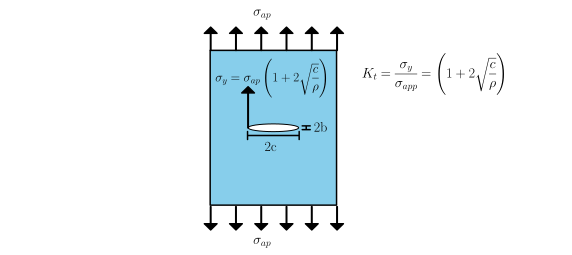

In [5]:
#HIDDEN
fig, ax = plt.subplots(figsize=(10, 4))


r2 = Rectangle([0.3, 0], 0.25, 1, ec='k', lw=1.5, fc='skyblue')
# plt.text(0.3+0.045, 0.85, '$S_2$', fontsize=14, zorder=9)
ax.add_patch(r2)
# plt.plot([0+0.3, 0.2+0.3], [0.3, 0.3], c='k', lw=1.5, zorder=9)
e1 = Ellipse([0.425, 0.5], 0.1, 0.05, zorder=9, fc='w', ec='k')
# plt.arrow(0.4, 0.4, 0.075, 0, head_width=0.075, head_length=0.0,
#           ec='k', lw=1.5, fc='k', zorder=9, stylr='')

plt.annotate(s='', xy=(0.345+0.025,0.45), xytext=(0.455+0.025,0.45),
             arrowprops=dict(arrowstyle='|-|, widthA=0.4,widthB=0.4', linewidth=1.5))

plt.text(0.325+0.115/2+0.025, 0.35, '2c', fontsize=14)


plt.annotate(s='', xy=(0.49, 0.475), xytext=(0.49,0.525),
             arrowprops=dict(arrowstyle='|-|, widthA=0.4,widthB=0.4', linewidth=1.5))

plt.text(0.505, 0.475, '2b', fontsize=14)

ax.add_patch(e1)
for i in np.linspace(0.3, 0.55, 6):
    plt.arrow(i+0.001, -0.01, 0, -0.11, head_width=0.025, head_length=0.04,
          ec='k', lw=1.5, fc='k', zorder=9)
    plt.arrow(i+0.001, 1, 0, 0.11, head_width=0.025, head_length=0.04,
          ec='k', lw=1.5, fc='k', zorder=9)

ax.arrow(0.3+0.05+0.025, 0.5, 0, 0.225, head_width=0.025, head_length=0.04,
          lw=1.5, fc='k', zorder=11)
plt.text(0.125+0.16+0.025, 0.8, r'$\sigma_{y} = \sigma_{ap} \left(1 + 2 \sqrt{ \displaystyle \frac{c}{\rho}} \right)$', fontsize=13)
# plt.text(0.095+0.3, 0.34, '$A_1$', fontsize=14, zorder=9)
# ax.arrow(0.1+0.3, -0.01, 0, -0.14, head_width=0.025, head_length=0.04,
#           lw=1.5, fc='k')
# plt.text(0.125+0.3, -0.15, '$F_2$', fontsize=14)
plt.text(0.085+0.3, 1.225, '$\sigma_{ap}$', fontsize=14)
plt.text(0.085+0.3, -0.25, '$\sigma_{ap}$', fontsize=14)

plt.text(0.6, 0.825, r'$K_t = \displaystyle \frac{\sigma_{y}}{\sigma_{app}} = \left(1 + 2 \sqrt{ \displaystyle \frac{c}{\rho}} \right)$', fontsize=14)

# plt.plot([0.3, 0.325], [0.5, 0.5], c='w', lw=2, zorder=4)
# plt.plot([0.475, 0.51], [0.5, 0.5], c='w', lw=2, zorder=4)

ax.set_xlim(-0.1, 1)
ax.set_ylim(-0.2, 1.2)

ax.axis('off')
plt.show()

Now we may consider that we increase $\sigma_{ap}$ until the material fails. In this case, what do you think $\sigma_y$ would be?

We may consider that on the defect tip, we reached the theoretical failure stress that we modeled earlier deriving from the Lennard-Jones potential, that is, mathematically we find that:

\begin{equation}\label{eq:sig_theo_Kt}
\begin{array}{ll}
\sigma_y & = \sigma_{ap}  \ K_t \\
\ \downarrow & \ \ \ \ \downarrow \\
\sigma_{th} & = \sigma_{f} \  K_t
\end{array}
\end{equation}


Now, **the gap between $\sigma_{th}$ and $\sigma_{f}$** shows to us **how much one can improve the material's strength by reducing the defects introduced during its processing steps**.

**Or:**

How a specific material **can "resist" to the decrease of strength** due to the **defects introduced during the processing steps**.

We now may wonder if there is a criterion for failure based on the **characteristics of the material** and **of the defects** and if there is, **what is its analytical form**!

# Irwin Failure Criterion

We recall from [Lesson 1](./lesson_1) that the theoretical strength of a material, $\sigma_{th}$ can be described as:

\begin{equation}\label{eq:sigma_th}
\sigma_{th} = \sqrt{\frac{E \gamma_0}{a_0}}
\end{equation}


From experimental results one can find the following relationships:

\begin{equation}\label{eq:sth_ineq}
\frac{E}{5} \gt \sigma_{th} \gt \frac{E}{10}
\end{equation}


\begin{equation}\label{eq:sexp_ineq}
\frac{E}{100} \gt \sigma_{th} \gt \frac{E}{1000}
\end{equation}


This difference is explained by the stress intensity factor:

\begin{equation}\label{eq:sf}
\begin{array}{ll}
\sigma_y & = \sigma_{ap}  \ K_t \\
\ \downarrow & \ \ \ \ \downarrow \\
\sigma_{th} & = \sigma_{f} \  K_t
\end{array}
\end{equation}


Which for an elliptical small defect we found it could be described as:

\begin{equation}\label{eq:sif_def}
K_t \approx 2 \sqrt{\frac{c}{\rho}}
\end{equation}


Substituting the definition of the stress intensity factor, Equation \ref{eq:sif_def}, into the theoretical strength, Equation \ref{eq:sigma_th} we can find:

\begin{equation}\label{eq:pre_irw}
\sqrt{\frac{E \gamma_0}{a_0}} = \sigma_f  \left( 2 \sqrt{\frac{c}{\rho}}\right)
\end{equation}


Solving for the failure stress, $\sigma_f$, we find the Irwin Failure Criteria:
\begin{equation}\label{eq:irwin}
\sigma_f = \left( \frac{E \gamma_0}{a_0} \frac{\rho}{4 c} \right)^{\frac{1}{2}}
\ \ {\text{Irwin Failure Criteria}}
\end{equation}


The first term on the parenthesis is related to properties that belongs to the material. The second term accounts for the geometry and size of the defect. 

Now, before proceeding, let's review our insight about the ductility of materials.

# Ductility of Materials

We have a natural feeling for deciding which material is ductile and which one is fragile, for example:
<center>
<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  overflow:hidden;padding:10px 5px;word-break:normal;}
.tg th{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  font-weight:normal;overflow:hidden;padding:10px 5px;word-break:normal;}
.tg .tg-0lax{text-align:left;vertical-align:top}
</style>
<table class="tg">
<thead>
  <tr>
    <th class="tg-0lax">Fragile</th>
    <th class="tg-0lax">Ductile</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td class="tg-0lax">Ice</td>
    <td class="tg-0lax">Steel</td>
  </tr>
  <tr>
    <td class="tg-0lax">Glass</td>
    <td class="tg-0lax">Lead</td>
  </tr>
  <tr>
    <td class="tg-0lax">Chalk</td>
    <td class="tg-0lax">Copper</td>
  </tr>
</tbody>
</table>
</center>    

This however, occurs at room temperature and standard conditions. There are multiple conditions that may change the behavior of these materials, such as:
- Temperature effect (i.e. glass $T_g$, Ductile-to-Brittle Transition Temperature)
- Load application rate (piche, polymers)
- Environment conditions (luminosity, humidity, hydrogen)

<span id="call-ref_db_trans" class="img_container center" style="display: inline_block; vertical-align: top; text-align: center;" > <img alt="test" src="https://yenaengineering.nl/wp-content/uploads/2020/11/fm-3-dbtt-2.png" style="display:block; margin-left: auto; margin-right: auto; text-align: left;" title="caption" align="center" width="500" height="600" /> <div class="img_caption" style="border-style: solid; border-width: 2px; border-radius: 5px; border-color:lightgrey; padding: 2px 5px; text-align: left; width=980px"><b>Figure 1:</b> Ductile-Brittle transition temperature for mild steel <a href="#cit-ref_db_trans">[1]</a>.</div> </span>


Now one question can be made: Is there any relationship between the strength of a material and its ductility?

# The Fracture Toughness - $K_{IC}$

Let's consider how the tensile stress normal to the crack opening direction behaves in front of the crack. For doing this, we consider the Mode I of fracture, which is the *opening of the crack by tensile stress*.

<span id="call-ref_mode" class="img_container center" style="display: inline_block; vertical-align: top; text-align: center;" > <img alt="test" src="https://www.researchgate.net/profile/Benoit_Derode/publication/258004229/figure/download/fig11/AS:669534277083151@1536640819817/Les-trois-modes-de-rupture-dune-fracture-Mode-I-ouverture-normale-aux-epontes-Mode.png" style="display:block; margin-left: auto; margin-right: auto; text-align: left;" title="caption" align="center" width="500" height="600" /> <div class="img_caption" style="border-style: solid; border-width: 2px; border-radius: 5px; border-color:lightgrey; padding: 2px 5px; text-align: left; width=980px"><b>Figure 2:</b> The three different modes of fracture: Mode I - tensile opening, Mode II - In plane shear, Mode III - Antiplane shear <a href="#cit-ref_mode">[2]</a>.</div> </span>


We might expect that as we move further away from the crack tip, the concentration of the force lines decrease and as a consequence the stress decays towards the applied stress.

Considering only the vicinity of the defect it is possible to find an analytical equation that describes how the stress decays. This may be visualized in the blue sample under tensile stress below. The decay of the local stress in the front of a defect is described too.

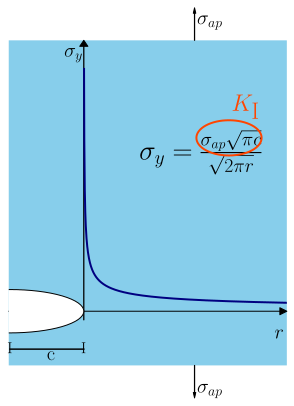

In [194]:
#HIDDEN

r = np.linspace(1e-3, 1, 1000)
c = 1
sigma_app = 10
fig = plt.figure(figsize=(5, 6))
plt.plot(r, sigma_app * (np.pi * c)**0.5 / (2*np.pi*r)**0.5, lw=2, c='Navy')
plt.ylim(-50, 250)
plt.xlim(-0.305, 0.825)

e = Ellipse([-0.3, 0], 0.6, 40,  facecolor='w', edgecolor='k', zorder=10)
plt.gca().add_patch(e)
arrowed_spines(fig, plt.gca(), ylim=[-8, 250])
add_interval(plt.gca(), [-0.3, -0.0001], [-35, -35], "II")
plt.text(-0.15, -45, 'c', c='k', fontsize=20)
plt.text(-0.08, 235, '$\sigma_y$', c='k', fontsize=20)
plt.text(0.775, -25, '$r$', c='k', fontsize=20)
plt.arrow(0.45, -50, 0, -30., fc='k', ec='k', lw = 1, 
             head_width=0.01, head_length=5,
             length_includes_head= True, clip_on = False)
plt.text(0.46, -75, '$\sigma_{ap}$', c='k', fontsize=20)

plt.arrow(0.45, 250, 0, 30., fc='k', ec='k', lw = 1, 
             head_width=0.01, head_length=5,
             length_includes_head= True, clip_on = False)
plt.text(0.46, 265, '$\sigma_{ap}$', c='k', fontsize=20)
plt.text(0.225, 140, r'$\sigma_y = \frac{\sigma_{ap}\sqrt{\pi c}}{\sqrt{2 \pi r}}$', c='k', fontsize=28)

e = Ellipse([0.59, 160], 0.265, 32.5, lw=2,  facecolor='none', edgecolor='orangered', zorder=10)
plt.gca().add_patch(e)
plt.gca().set_facecolor('skyblue')
plt.text(0.6, 185, r'$K_{{\textrm I}}$', c='orangered', fontsize=24)
plt.show()

One can see that the local stress, $\sigma_y$, is inversely proportional to the distance from the crack tip, $r$. We can check that such equation is only valid on the vicinity of the defect when we analyze the behavior of it on both limits (if we consider $r \rightarrow 0$, then $\sigma_y \rightarrow \infty$, which is not real, and conversely, $r \rightarrow \infty$, then $\sigma_y \rightarrow 0$, which is also not true).

Another interesting aspect is that we also find that there is a constant on the numerator which comprises the applied stress and the size of the defect. This is the **stress intensity factor**, which in mode I is represented by $K_I$.

If we increase the applied stress, $\sigma_{app}$, until the material breaks, we can define the critical stress intensity factor, $K_{Ic}$:

\begin{equation}\label{eq:kic}
\begin{array}{ll}
K_{{\textrm I}} & = \sigma_{ap}  \ \sqrt{\pi c} \\
\ \downarrow & \ \ \ \ \downarrow \\
K_{{\textrm Ic}} & = \sigma_{f} \  \sqrt{\pi c}
\end{array}
\end{equation}

The **critical stress intensity factor** is also known as the **fracture toughness** and has units of $\textrm{MPa} . \textrm{m}^{\frac{1}{2}}$

Now considering this new quantity, analyze the following pairs of values of failure stress, $\sigma_{f}$, and defect size, $c$:

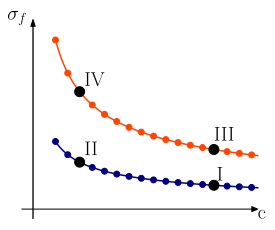

In [117]:
#HIDDEN
# nbi:right
K_Ic_1 = 4
K_Ic_2 = 10
fig = plt.figure(figsize=(4, 3))
sigma_f = lambda K_Ic, c: K_Ic/(np.pi*c)**0.5
cs = np.linspace(1e-1, 1, 100)
plt.plot(cs, sigma_f(K_Ic_1, cs), '-o', markevery=6,  c='navy', zorder=5)
plt.plot(cs, sigma_f(K_Ic_2, cs), '-o', markevery=6,  c='orangered', zorder=5)

plt.scatter([0.805], [sigma_f(K_Ic_2, 0.805)], marker='o', c='k', s=100, zorder=10)
plt.scatter([0.2075], [sigma_f(K_Ic_2, 0.2075)], marker='o', c='k', s=100, zorder=10)
plt.scatter([0.805], [sigma_f(K_Ic_1, 0.805)], marker='o', c='k', s=100, zorder=10)
plt.scatter([0.2075], [sigma_f(K_Ic_1, 0.2075)], marker='o', c='k', s=100, zorder=10)

plt.text(0.805*1.015, sigma_f(K_Ic_1, 0.805)*1.2, r'I', fontsize=20, c='k')
plt.text(0.2075*1.1, sigma_f(K_Ic_1, 0.2075)*1.15, r'II', fontsize=20, c='k')
plt.text(0.805, sigma_f(K_Ic_2, 0.805)*1.15, r'III', fontsize=20, c='k')
plt.text(0.2075*1.1, sigma_f(K_Ic_2, 0.2075)*1.05, r'IV', fontsize=20, c='k')

arrowed_spines(fig, plt.gca(), ylim=[-1, 20], xlim=[-0.05, 1])

plt.text(1, -1, 'c', fontsize=20)
plt.text(-0.115, 20, r'$\sigma_f$', fontsize=20)
# plt.axhline(8, ls='--', c='navy')
# plt.text(0.01, 8.5, r'$\sigma_{ys, 1}$', fontsize=20, c='navy')

# plt.axhline(13, ls='--', c='orangered')
# plt.text(0.01, 13.5, r'$\sigma_{ys, 2}$', fontsize=20, c='orangered')

plt.show()

In [165]:
#HIDDEN
# nbi:right

question = '''
          <div style="align_content: center; font-size: 12px; font-weight: bold; width: 140%!important;">
          Which affirmation is right?
          
          <p>a)   $K_{IC, IV} > K_{IC, III} > K_{IC, II} > K_{IC, I}$</p>
          
          <p>b)  $K_{IC, I} > K_{IC, II} > K_{IC, III} > K_{IC, IV}$</p>
          
          <p>c) $K_{IC, IV} = K_{IC, III} > K_{IC, II} = K_{IC, I}$</p>
          
          <p>d) $K_{IC, II} = K_{IC, IV} > K_{IC, III} = K_{IC, I}$</p>
          </div>
          '''
Q1 = create_multipleChoice_widget(question,['a','b','c', 'd'], 'c')
Q1.layout = widgets.Layout(display='flex',
                               flex_flow='column',
                               align_items='center',
                               align_content='center',
                               justify_content='center',
                               width='100%')
display(Q1)

Did you get it right in the first try? No worries, let's explain it!

What we have is in fact two different materials:

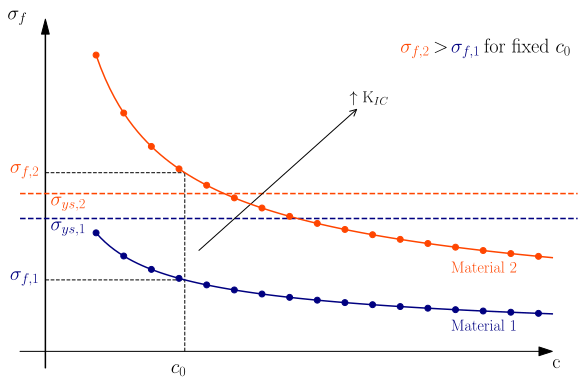

In [287]:
#HIDDEN
K_Ic_1 = 4
K_Ic_2 = 10
fig = plt.figure(figsize=(10, 6))
sigma_f = lambda K_Ic, c: K_Ic/(np.pi*c)**0.5
cs = np.linspace(1e-1, 1, 100)
plt.plot(cs, sigma_f(K_Ic_1, cs), '-o', markevery=6,  c='navy', zorder=5)
plt.text(0.8, 1.25, r'Material 1', fontsize=16, c='navy')
plt.plot(cs, sigma_f(K_Ic_2, cs), '-o', markevery=6,  c='orangered', zorder=5)
plt.text(0.8, 4.75, r'Material 2', fontsize=16, c='orangered')

arrowed_spines(fig, plt.gca(), ylim=[-1, 20], xlim=[-0.05, 1])
plt.annotate(r'$\uparrow$ K$_{IC}$', xy=(0.3, 6), xytext=(0.6, 15),
             arrowprops=dict(arrowstyle='<-', linewidth=1), fontsize=16)

plt.plot([0.275, 0.275], [0, sigma_f(K_Ic_2, 0.275)], c='k', ls='--', lw=1)
plt.plot([0, 0.275], [sigma_f(K_Ic_1, 0.275), sigma_f(K_Ic_1, 0.275)], c='k', ls='--', lw=1)
plt.plot([0, 0.275], [sigma_f(K_Ic_2, 0.275), sigma_f(K_Ic_2, 0.275)], c='k', ls='--', lw=1)
plt.text(-0.07, sigma_f(K_Ic_1, 0.275), r'$\sigma_{f, 1}$', fontsize=20, c='navy')
plt.text(-0.07, sigma_f(K_Ic_2, 0.275), r'$\sigma_{f, 2}$', fontsize=20, c='orangered')

plt.text(0.275*0.9, -1.3, r'$c_0$', fontsize=20, c='k')
plt.text(0.7, 18, r'$\sigma_{f, 2}$', fontsize=20, c='orangered')
plt.text(0.765, 18, r'$>$', fontsize=20, c='k')
plt.text(0.8, 18, r'$\sigma_{f, 1}$', fontsize=20, c='navy')
plt.text(0.865, 18, r'for fixed $c_0$', fontsize=20, c='k')



plt.text(1, -1, 'c', fontsize=20)
plt.text(-0.075, 20, r'$\sigma_f$', fontsize=20)
plt.axhline(8, ls='--', c='navy')
plt.text(0.01, 7.3, r'$\sigma_{ys, 1}$', fontsize=20, c='navy')

plt.axhline(9.5, ls='--', c='orangered')
plt.text(0.01, 8.8, r'$\sigma_{ys, 2}$', fontsize=20, c='orangered')

plt.show()

Consider that we take two perfect samples (single crystals, no defects) of these materials and introduce a single defect of size $c_0$. 

If we test these samples applying increasingly higher tensile stress, we see that: 
> 1. The failure stress of the **<span style="color:orangered">Material 2 </span>** is higher than the one of **<span style="color:navy">Material 1</span>**.
> 1. If these materials have the yield strengths described by the horizontal dashed lines, then, **<span style="color:orangered">Material 2 </span>** have displayed plastic deformation before failure, while **<span style="color:navy">Material 1</span>** broke before showing any plasticity

In other words, **<span style="color:navy">Material 1</span>**  is an overall example of a *ceramic* while **<span style="color:orangered">Material 2 </span>** is the example of a *metal* (both at room temperatures).

Another insight that we can derive from this plot:
> We can have a metal behaving as a ceramics without changing environmental conditions such as temperature. All is needed is that its defect is big enough to reduce the failure stress to levels below the yield strength! **The lack of understanding of this concept was responsible to multiple failures where people did not expect brittle fractures in metal structures.**


# Overall Behavior of Materials

We can see the overall behavior of the classes of materials regarding their strength, $\sigma_f$, and their fracture toughness, $K_{IC}$:



<span id="call-ref_ashby" class="img_container center" style="display: inline_block; vertical-align: top; text-align: center;" > <img alt="test" src="https://upload.wikimedia.org/wikipedia/commons/a/a4/Fracture_toughness_vs._Strength.jpg" style="display:block; margin-left: auto; margin-right: auto; text-align: left;" title="caption" align="center" width="500" height="600" /> <div class="img_caption" style="border-style: solid; border-width: 2px; border-radius: 5px; border-color:lightgrey; padding: 2px 5px; text-align: left; width=980px"><b>Figure 3:</b> Ashby plot of the fracture toughness, $K_{IC}$, and the strength, $\sigma_f$ <a href="#cit-ref_ashby">[3]</a>.</div> </span>


This behavior can be explained by the relationship of these properties:


\begin{array}{l}
\sigma_f \ \ \text{(Strength)} \longrightarrow \text { bond energy } +  \text { defects } \\
\mathrm{K}_{\mathrm{Ic}} \ \ \text{(Fracture Toughness)} \longrightarrow \text { bond energy } + \text{plastic deformation} 
\end{array}


One should keep in mind that toughness and fracture toughness are fundamentally different properties!
Consider the graph below, which represents the stress-strain curve for a general material that shows plastic deformation:

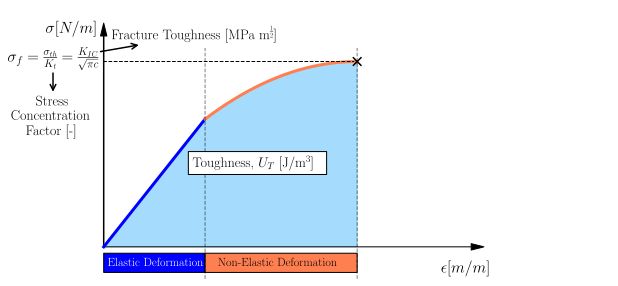

In [164]:
#HIDDEN
fig, ax = plt.subplots(figsize=(10, 5))
def force(displacement):
    E = 1
    var = -2.5
    force_vals_elastic = E *  displacement[displacement < 0.2] 
    force_vals_non_elastic = E *  displacement[(displacement >= 0.2)*(displacement < 0.5)] +\
                             E *  (displacement[(displacement >= 0.2)*(displacement < 0.5)]**2)[0] -\
                             E *  displacement[(displacement >= 0.2)*(displacement < 0.5)]**2
    x = displacement[(displacement >= 0.5)]
    force_vals_break = force_vals_non_elastic[-1] * np.exp(var*(x-1.25)) / (1 + np.exp(var*(x-1.25)))*x**-0.2
    force_vals = np.concatenate([force_vals_elastic, force_vals_non_elastic, force_vals_break])
    return force_vals
plt.plot(x1, 200*force(x1), c='blue', lw=3)
x2 = np.linspace(0.2, 0.5001, 1000)
plt.plot(x2, 200*force(x2), c='coral', lw=3)
x = np.linspace(0, 0.50, 1000)
plt.fill_between(x, 200*force(x), color='lightskyblue', alpha=0.75)
plt.scatter(0.5, 58, marker='x', s=75, c='k', zorder=4)

plt.xlim(-0.1, 1)
plt.ylim(-10, 75)
plt.arrow(0, 0, 0, 70., fc='k', ec='k', lw = 1, 
             head_width=0.0125, head_length=4,
             length_includes_head= True, clip_on = False)
plt.text(-0.115, 67, r'$\sigma [N/m²]$', c='k', fontsize=16)
plt.arrow(0, 0, 0.75, 0., fc='k', ec='k', lw = 1, 
             head_width=2, head_length=0.025,
             length_includes_head=True, clip_on=False)
plt.text(0.665, -8, r'$\epsilon [m/m]$', c='k', fontsize=16)
r1 = Rectangle([0, -2], 0.2, -6, ec='k', lw=1, fc='blue')
ax.add_patch(r1)
r2 = Rectangle([0.2, -2], 0.3, -6, ec='k', lw=1, fc='coral')
ax.add_patch(r2)
plt.text(0.0075, -6, r'Elastic Deformation', c='w', fontsize=12)
plt.text(0.225, -6, r'Non-Elastic Deformation', c='k', fontsize=12)
plt.text(0.175, 25, r'Toughness, $U_T$ [J/m$^3$]', fontweight='bold', c='k', fontsize=14, bbox=dict(facecolor='w'))
plt.axvline(0.2, ymax=0.85, c='k', ls='--', lw=1, zorder=3, alpha=0.5)
plt.axvline(0.5, ymax=0.85, c='k', ls='--', lw=1, zorder=3, alpha=0.5)
plt.axhline(58, c='k', ls='--', lw=1, zorder=3, xmin=0.09, xmax=0.54)
plt.text(-0.19, 58, r'$\sigma_f = \frac{\sigma_{th}}{K_t} = \frac{K_{IC}}{\sqrt{\pi c}}$', c='k', fontsize=16)
plt.annotate(r'Fracture Toughness [MPa m$^{\frac{1}{2}}$]',
             xy=(-0.01, 61),
             xytext=(0.015, 65),
             textcoords='data',
             fontsize=14, 
             arrowprops=dict(arrowstyle= '<-',
                             color='k',
                             lw=1.5,
                             ls='-')
           )

plt.annotate('Stress \nConcentration \nFactor [-]',
             xy=(-0.1, 55),
             xytext=(-0.1, 35),
             textcoords='data',
             fontsize=14, 
             horizontalalignment='center',
             arrowprops=dict(arrowstyle= '<-',
                             color='k',
                             lw=1.5,
                             ls='-'))
plt.gca().axis('off')
plt.show()

> **Do not get confused!**
>
> *Strength*, *Toughness*, *Stress Concentration Factor* and *Fracture Toughness* are all different quantities and even though are closely related, they have distinct units and physical meaning:
> - The strength, $\sigma_f$, of a specific material is the stress at failure of a sample under a specific test. It is not intrinsic to the material as it depends on the presence and geometrical features of the defects;
> - $\sigma_f$ is related to the stress concentration factor, $K_t$, by the fact that the presence of defects in the sample increases the stress felt at the crack tip. When we reach the failure stress, the value "felt" at the crack tip is the theoretical stress, $\sigma_{th}$;
> - The susceptibility of a material to this stress concentration effect for a given defect of size $c$ is intrinsic to the material and it is known as the Fracture Toughness (also known as Critical Stress Intensity Factor), $K_{IC}$. This quantity represents the resistance to the start of crack propagation;
> - Finally, the Toughness, $U_T$, is the ability of a material to absorb energy and plastically deform without fracturing, it has units of Joules by cubic meter.

# Application of the Concepts

Let's now apply this new set of tools to different scenarios and understand multiple situations that we encounter in our day-today lives!

## Crack Deflection

Let's consider two different ordinary materials, the mortar and concrete. One may even wrongly consider them the same material, but they have very distinct characteristics and even applications!

Consider first the microstructure of them:


<span id="call-ref_micro" class="img_container center" style="display: inline_block; vertical-align: top; text-align: center;" > <img alt="test" src="./Mortar_and_concrete.png" style="display:block; margin-left: auto; margin-right: auto; text-align: left;" title="caption" align="center" width="300" /> <div class="img_caption" style="border-style: solid; border-width: 2px; border-radius: 5px; border-color:lightgrey; padding: 2px 5px; text-align: left; width=980px"><b>Figure 4:</b> Examples of Concrete and Mortar. Adapted from <a href="#cit-ref_micro">[4]</a>.</div> </span>


It is clear that the concrete has a distinct phase, the aggregates. Otherwise, the composition of mortar and concretes are equal. They have very important contributions to the properties of such materials. Let's check the applications of these materials and see if we have any clue!

>**Mortar**:
>
> Used as a binding agent between other construction materials

>**Concrete**:
>
> Used as a construction material


Some questions that you might have right now:

- Why do people don't make structures of mortar alone?
- Why do they need to add aggregates if they are bigger potential defects?
- Wouldn't the aggregates decrease their strength?

Let's check the experimental results:

<span id="call-ref_cs" class="img_container center" style="display: inline_block; vertical-align: top; text-align: center;" > <img alt="test" src="https://www.researchgate.net/profile/Hakim-Abdelgader-2/publication/272564768/figure/tbl1/AS:614271020961807@1523465032906/Cylinder-compressive-strength-of-concrete-and-mortar-at-28-days_W640.jpg" style="display:block; margin-left: auto; margin-right: auto; text-align: left;" title="caption" align="center" width="300" /> <div class="img_caption" style="border-style: solid; border-width: 2px; border-radius: 5px; border-color:lightgrey; padding: 2px 5px; text-align: left; width=980px"><b>Figure 5:</b> Compressive strength of Concrete and Mortar. From <a href="#cit-ref_cs">[5]</a>.</div> </span>





Indeed the compressive strength of the mortar is roughly the double of the one of the concrete. Let's try to use the concepts that we learned to understand why no one uses mortar as a building material even though it has a higher strength!

We know that the stress at the tip of the defect is increased due to the concentration of the force lines. 

However, when we consider a direction that is not perpendicular to the application of the forces we can intuitively expect that the stress "felt" at that direction is lower. 

This is exactly what happens:

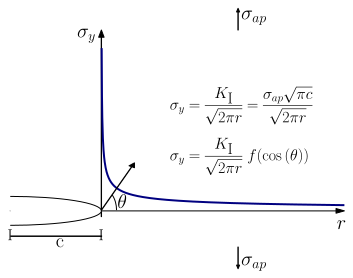

In [138]:
#HIDDEN

r = np.linspace(1e-3, 1, 1000)
c = 1
sigma_app = 10
fig = plt.figure()
plt.plot(r, sigma_app * (np.pi * c)**0.5 / (2*np.pi*r)**0.5, lw=2, c='Navy')
plt.ylim(-50, 250)
plt.xlim(-0.3, 0.8)

e = Ellipse([-0.3, 0], 0.6, 40,  facecolor='w', edgecolor='k', zorder=10)
plt.gca().add_patch(e)
arrowed_spines(fig, plt.gca(), ylim=[-8, 250])
add_interval(plt.gca(), [-0.3, -0.0001], [-35, -35], "II")
plt.text(-0.15, -50, 'c', c='k', fontsize=20)
plt.text(-0.08, 240, '$\sigma_y$', c='k', fontsize=20)
plt.text(0.775, -25, '$r$', c='k', fontsize=20)
plt.arrow(0.45, -50, 0, -30., fc='k', ec='k', lw = 1, 
             head_width=0.01, head_length=5,
             length_includes_head= True, clip_on = False)
plt.text(0.46, -75, '$\sigma_{ap}$', c='k', fontsize=20)

plt.arrow(0.45, 250, 0, 30., fc='k', ec='k', lw = 1, 
             head_width=0.01, head_length=5,
             length_includes_head= True, clip_on = False)
plt.text(0.46, 265, '$\sigma_{ap}$', c='k', fontsize=20)
plt.text(0.225, 140, r'$\sigma_y = \displaystyle \frac{K_{\textrm I}}{\sqrt{2 \pi r}} = \frac{\sigma_{ap}\sqrt{\pi c}}{\sqrt{2 \pi r}}$', c='k', fontsize=16)
plt.text(0.225, 70, r'$\sigma_y = \displaystyle \frac{K_{\textrm I}}{\sqrt{2 \pi r}} \ f(\cos{(\theta))}$', c='k', fontsize=16)
ax2 = plt.gca().twinx()
y_0 = 0.17
x_1 = 0.1
y_1 = 0.2
ax2.arrow(0.0, y_0, x_1, y_1, fc='k', ec='k', lw = 1, 
          head_width=0.02, head_length=0.02)
arc = ax2.add_patch(Arc([0, y_0], x_1, y_1, theta1=0, theta2=np.degrees(np.arctan(y_1/x_1)), color='k'))
plt.text(0.0525, 0.18, r'$\theta$', c='k', fontsize=20)

ax2.set_ylim(0, 1)
ax2.axis('off')
plt.show()

<div id="call-ref_book"</div>
The closed form of f is more complex as it is derived from a polar coordinates analysis of the problem. For more information check the work of Professor Brian Lawn <a href="#cit-ref_book">[6]</a>. 

What we need to understand is that if by some reason the crack needs to deviate from its original path, there is a decrease on the stress at the tip of the crack, which is proportional to the cosine of the angle of this deviation with respect to the original direction.

The next graph presents this decrease:

 

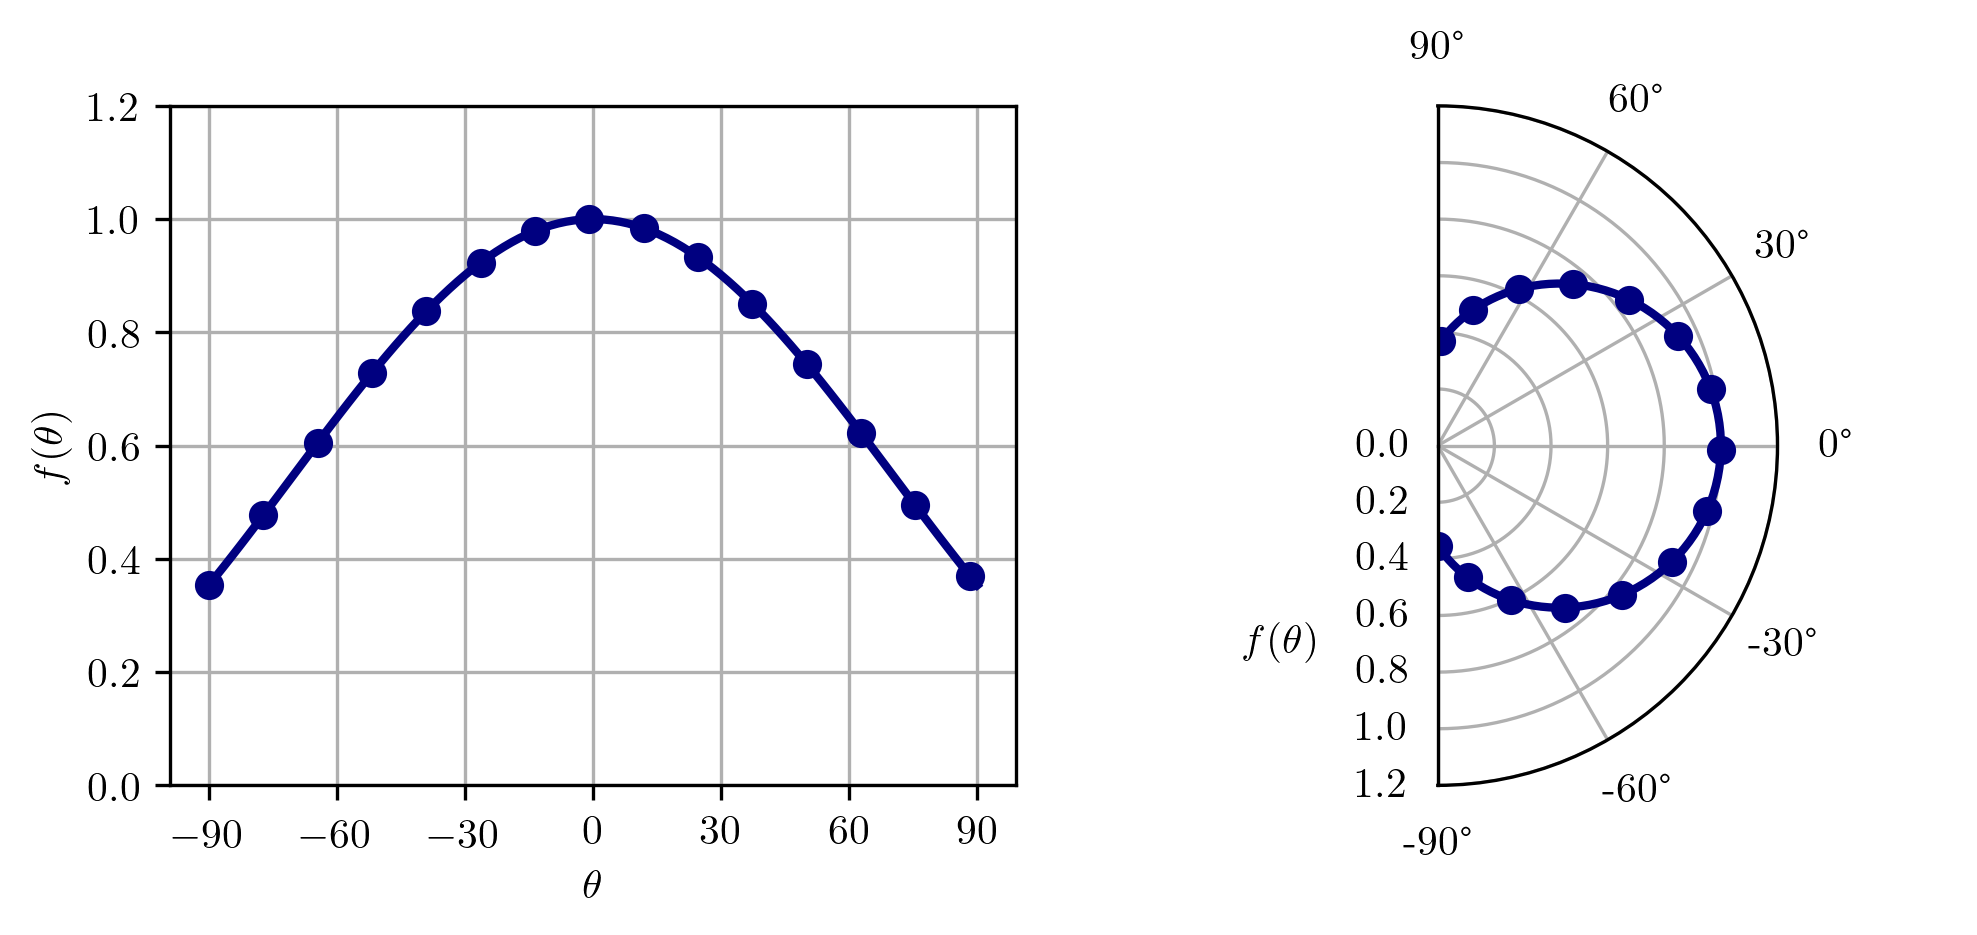

In [167]:
# HIDDEN
%config InlineBackend.figure_formats = ['png']
def f_theta(theta):
    return np.cos(theta / 2)**3

# fig, axs = plt.subplots(1, 2, subplot_kw=dict(polar=True))
fig = plt.figure(figsize=(8, 3), dpi=300)
ax1 = plt.subplot(121)
ax2 = plt.subplot(122, projection='polar')

thetas = np.linspace(-(np.pi/2), (np.pi/2), 100)
ax1.plot(np.rad2deg(thetas), f_theta(thetas), '-o', markevery=7, c='navy', lw=2)
ax1.set_ylim(0, 1.2)
ax1.set_xlabel(r'$\theta$')
ax1.set_ylabel(r'$f(\theta)$')
ax1.set_xticks(np.linspace(-90, 90, 7))
ax1.grid()

ax2.plot(thetas, f_theta(thetas), '-o', markevery=7, c='navy', lw=2)
ax2.set_ylim(0, 1.2)
# plt.ylim(-np.pi/2, np.pi/2)
ax2.set_xlim(-np.pi/2, np.pi/2)
ax2.set_xticks(np.linspace(-np.pi/2, np.pi/2, 7))
ax2.text(-np.pi/1.35, 1., r'$f(\theta)$')
# axs[1].projection('polar')
plt.show()

You can visualize the effect of the crack deflection on the example below. Change the values of the angle theta below and see how the stress at the tip of the defect changes:

In [206]:
#HIDDEN
def see_theta(theta_deg):
    %config InlineBackend.figure_formats = ['png']

    theta = np.deg2rad(theta_deg)
    c = 1
    sigma_app = 30
    fig = plt.figure(figsize=(8, 3), dpi=300)
    ax1 = plt.subplot(121)
    ax2 = plt.subplot(122, projection='polar')
    r = np.linspace(1e-3, 1, 1000)
    ax1.plot(r, sigma_app * (np.pi * c)**0.5 / (2*np.pi*r)**0.5 * f_theta(theta), lw=2, c='Navy')
    ax1.plot(r, sigma_app * (np.pi * c)**0.5 / (2*np.pi*r)**0.5 * f_theta(0), lw=1, ls='--', c='Navy', label=r'$\sigma_y$ with $\theta=0$')
    ax1.scatter(-10, -10, c='grey',marker=r'$\rightarrow$',s=120, label='Direction of Fracture' )
    ax1.set_ylim(-150, 150)
    e = Ellipse([-0.45, 0], 0.9, 40,  facecolor='w', edgecolor='k', zorder=10)
    ax1.add_patch(e)
    r = Rectangle([-0.9, -25], 0.45, 45,  facecolor='w', edgecolor='w', zorder=11)
    ax1.add_patch(r)
    arrowed_spines(fig, ax1, ylim=[-8, 250], xlim=[-0.2, 1])
    ax1.annotate(s='', xy=(-0.3, -35), xytext=(-0.0001,-35),
             arrowprops=dict(arrowstyle='|-|, widthA=0.4,widthB=0.4', linewidth=1))
    
    ax1.text(-0.175, -55, 'c', c='k', fontsize=14)
    ax1.text(-0.175, 240, '$\sigma_y$', c='k', fontsize=14)
    ax1.text(0.975, -25, '$r$', c='k', fontsize=14)
    ax1.set_xlim(-0.3, 0.8)
    ax1.axis('off')
    ax1.legend(fontsize=8)
    ax3 = ax1.twinx()
    ax3.axis('off')
    plot_arrow(ax3, theta)
    ax1.arrow(0.45, -50, 0, -30., fc='k', ec='k', lw = 1, 
          head_width=0.05, head_length=5,
          length_includes_head= True, clip_on = False)
    ax1.text(0.485, -75, '$\sigma_{ap}$', c='k', fontsize=12)

    ax1.arrow(0.45, 220, 0, 30., fc='k', ec='k', lw = 1, 
              head_width=0.05, head_length=5,
              length_includes_head= True, clip_on = False)
    ax1.text(0.485, 230, '$\sigma_{ap}$', c='k', fontsize=12)
    
    ax2.plot([theta, theta], [0, 1.2])
    ax2.plot(thetas, f_theta(thetas), '-', markevery=7, c='navy', lw=2)
    ax2.plot(theta, f_theta(theta),'-o', c='orangered', zorder=3)
    ax2.plot([theta]*5, [0, 0.2, 0.4, 0.8, 1.2], '-', c='k')
    ax2.set_ylim(0.2, 1.2)
    ax2.set_xlim(-np.pi/2, np.pi/2)
    ax2.set_xticks(np.linspace(-np.pi/2, np.pi/2, 7))
    ax2.text(-np.pi/1.35, 1., r'$f(\theta)$')
interactive_plot = interactive(see_theta, theta_deg=widgets.FloatSlider(value=0,
                                                       min=-90,
                                                       max=90,
                                                       step=5,
                                                       description=r'$\theta \ [°]$',
                                                       readout_format='.2f'))
output = interactive_plot.children[-1]
output.layout.height = '550px'
interactive_plot.layout = widgets.Layout(display='flex',
                               flex_flow='column',
                               align_items='center',
                               align_content='center',
                               justify_content='center',
                               width='100%')
interactive_plot

interactive(children=(FloatSlider(value=0.0, description='$\\theta \\ [°]$', max=90.0, min=-90.0, step=5.0), O…

This have plenty of effects and explains one of the most common toughening mechanism, the *crack deflection*.

One can easily understand its effectiveness when comparing the resulting fracture surface (represented as a line below):

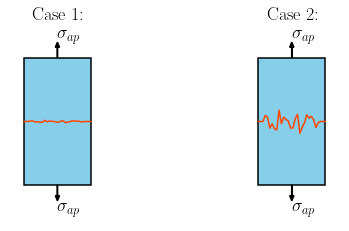

In [337]:
#HIDDEN

n = 30
x_1 = np.linspace(0.1, 0.5, n)
x_2 = np.linspace(1.5, 1.9, n)
y = np.ones(n) * 0.9 
np.random.seed(23)
noise = np.random.normal(0, 1, n)
noise[:3] = 0
noise[-3:] = 0
plt.plot(x_1, y+noise*0.0025, c='orangered')
plt.plot(x_2, y+noise*0.025, c='orangered')

r1 = Rectangle([0.1, 0.65], 0.4, 0.5, ec='k', lw=1.5, fc='skyblue')
plt.gca().add_patch(r1)
r2 = Rectangle([1.5, 0.65], 0.4, 0.5, ec='k', lw=1.5, fc='skyblue')
plt.gca().add_patch(r2)

plt.ylim(0.5, 1.35)
plt.xlim(0, 2)

plt.arrow(0.3, 1.15, 0, 0.04, head_width=0.025, head_length=0.02,
      ec='k', lw=1.5, fc='k', zorder=9)
plt.arrow(1.7, 1.15, 0, 0.04, head_width=0.025, head_length=0.02,
      ec='k', lw=1.5, fc='k', zorder=9)
plt.arrow(0.3, 0.65, 0, -0.04, head_width=0.025, head_length=0.02,
      ec='k', lw=1.5, fc='k', zorder=9)
plt.arrow(1.7, 0.65, 0, -0.04, head_width=0.025, head_length=0.02,
      ec='k', lw=1.5, fc='k', zorder=9)

plt.text(0.15, 1.3, r'Case 1:', fontsize=18)
plt.text(1.55, 1.3, r'Case 2:', fontsize=18)
plt.text(0.3, 0.55, r'$\sigma_{ap}$', fontsize=18)
plt.text(0.3, 1.225, r'$\sigma_{ap}$', fontsize=18)
plt.text(1.7, 0.55, r'$\sigma_{ap}$', fontsize=18)
plt.text(1.7, 1.225, r'$\sigma_{ap}$', fontsize=18)


plt.gca().axis('off')
plt.show()

The resulted surface area of Case 1 is clear smaller than the one created in Case 2. This suggests that the energy necessary to create such surfaces is indeed higher.

Thus, we can understand that the crack deflection done by the aggregates will increase the resulting work of fracture, $\gamma_{wof}$, and this explains why we need to add aggregates to the mortar in order to construct structural elements that should prevent by all means catastrophic failure!

## Comparison of Surface and Bulk Defects

Now consider the definition of the fracture toughness, Equation \ref{eq:kic} and solve for $\sigma_f$:

\begin{equation}\label{eq:sig_f}
\sigma_f = \dfrac{K_{IC}}{\sqrt{\pi c}}
\end{equation}

We see that the greater the size of the defect, the lower the failure stress. Conversely, when we increase the fracture toughness, the material is less susceptible to the defect size.

Now one question that may arise is if there is any difference if the defect is on the surface or on the bulk of the material. Consider these two cases below:

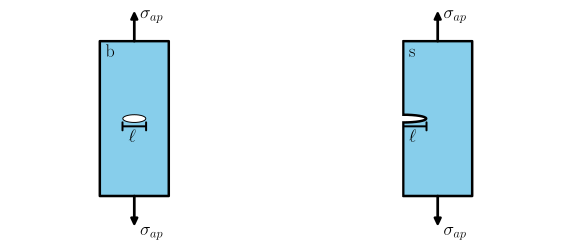

In [10]:
#HIDDEN
%config InlineBackend.figure_formats = ['svg']

fig, axs = plt.subplots(1, 2, figsize=(10, 4))


r2 = Rectangle([0.3, 0], 0.3, 1, ec='k', lw=2.5, fc='skyblue')
axs[0].add_patch(r2)
e1 = Ellipse([0.45, 0.5], 0.1, 0.05, zorder=9, fc='w', ec='k')
axs[0].add_patch(e1)

axs[0].arrow(0.1+0.3+0.05, 1, 0, 0.14, head_width=0.025, head_length=0.04,
          lw=2.5, fc='k')
axs[0].text(0.125+0.3+0.05, 1.15, '$\sigma_{ap}$', fontsize=18)
axs[0].arrow(0.1+0.3+0.05, 0, 0, -0.14, head_width=0.025, head_length=0.04,
          lw=2.5, fc='k')
axs[0].text(0.125+0.3+0.05, -0.25, '$\sigma_{ap}$', fontsize=18)

r2 = Rectangle([0.3, 0], 0.3, 1, ec='k', lw=2.5, fc='skyblue')
axs[1].add_patch(r2)
e1 = Ellipse([0.3, 0.5], 0.2, 0.05, zorder=9, fc='w', ec='k', lw=2.5)
axs[1].add_patch(e1)
r3 = Rectangle([0.19, 0], 0.1, 1, ec='w', lw=2.5, fc='w', zorder=10)
axs[1].add_patch(r3)


axs[1].arrow(0.1+0.3+0.05, 1, 0, 0.14, head_width=0.025, head_length=0.04,
          lw=2.5, fc='k')
axs[1].text(0.125+0.3+0.05, 1.15, '$\sigma_{ap}$', fontsize=18)
axs[1].arrow(0.1+0.3+0.05, 0, 0, -0.14, head_width=0.025, head_length=0.04,
          lw=2.5, fc='k')
axs[1].text(0.125+0.3+0.05, -0.25, '$\sigma_{ap}$', fontsize=18)

axs[0].annotate(s='', xy=(0.39,0.45), xytext=(0.51,0.45),
             arrowprops=dict(arrowstyle='|-|, widthA=0.4,widthB=0.4', linewidth=2))
axs[0].text(0.425, 0.35, r'$\ell$', fontsize=18, zorder=10)

axs[1].annotate(s='', xy=(0.29,0.45), xytext=(0.41,0.45),
             arrowprops=dict(arrowstyle='|-|, widthA=0.4,widthB=0.4', linewidth=2))
axs[1].text(0.325, 0.35, r'$\ell$', fontsize=18, zorder=10)

axs[0].text(0.325, 0.9, 'b', fontsize=18, zorder=10)
axs[1].text(0.325, 0.9, 's', fontsize=18, zorder=10)



for ax in axs:
    ax.axis('off')
    ax.set_xlim(-0.1, 1)
    ax.set_ylim(-0.2, 1.2)

plt.show()

Both samples are made of the same material, thus $K_{IC}$ is the same.

\begin{equation*}
\sigma_f = \dfrac{K_{IC}}{\sqrt{\pi c}}
\end{equation*}

\begin{equation*}
\sigma_{f, b} \ \sqrt{\pi \dfrac{\ell}{2}} = \sigma_{f, s} \ \sqrt{\pi \ell}
\end{equation*}

\begin{equation*}
\sigma_{f, b}^2 \ \pi \dfrac{\ell}{2} = \sigma_{f, s}^2 \ \pi \ell
\end{equation*}

\begin{equation*}
\dfrac{\sigma_{f, b}^2}{\sigma_{f, s}^2} = 2
\end{equation*}

\begin{equation*}
\dfrac{\sigma_{f, b}}{\sigma_{f, s}} = \sqrt{2}
\end{equation*}

\begin{equation*}
\sigma_{f, s} = 0.7 \sigma_{f, b}
\end{equation*}

This result is of fundamental importance as it shows that for defects of same sizes, the defects on the surface are more critical as the mechanical strength of the sample with the defect on the surface is lower than the one with the defect in the bulk.

> This justifies a lot of situations, for example:
> - The use of surface treatments to increase the strength of glass components (such as using 
hydrofluoric acid to dissolve imperfections on the surface of soda lime glasses, or using chemical substitution of cations to create compressive strength on the surface of the glass, such as the Gorilla Glass family)
> - Using machining to remove defects on the surface of advanced ceramics (for example 
prosthesis, where machining is used both for defining precisely the dimensions and to reduce the surface defects )

## Ball Milling

Another example where we can see the usefulness of the concepts learned in this lesson is the mechanisms behind ball milling!

The particles are broken by the impact between the balls and the material that is being milled. In simplified terms:

1. The rotation carries the balls up high and provides them with gravitational potential energy;
2. When the centrifugal acceleration equals the gravity one, the ball starts to fall, transforming the potential energy in kinetic energy;
3. During the impact of the balls with the material that is being milled, the kinetic energy is converted once again into stored elastic energy, deforming the material and stressing it until it fails;
4. In parallel, the relative movement of the balls provide milling through friction.





<span id="call-ref_bml" class="img_container center" style="display: inline_block; vertical-align: top; text-align: center;" > <img alt="test" src="https://www.911metallurgist.com/blog/wp-content/uploads/2016/02/ball-mill-animation.gif" style="display:block; margin-left: auto; margin-right: auto; text-align: left;" title="caption" align="center" width="350" /> <div class="img_caption" style="border-style: solid; border-width: 2px; border-radius: 5px; border-color:lightgrey; padding: 2px 5px; text-align: left; width=980px"><b>Figure 6:</b> Animation of ball milling. <a href="#cit-ref_bml">[7]</a>.</div> </span>


One good question is:

> **If we let the ball milling running for hours, or even days, will the size of the particulates decrease indefinitely?**

Obviously, this is not the case!

> What truly happens is:
> The balls will provide a constant compressive stress to the particulates, $\sigma_{impact}$, which will be able to break the particulates that have a critical defect, $c$,such that:
>\begin{equation*}
 \sigma_{impact} \ge \sigma_f(c) = \dfrac{K_{IC}}{\sqrt{\pi c}}
 \end{equation*}
>
> Once the particulates diameter $D$ becomes smaller than $c$, for sure the new critical defect, $c'$, will be smaller than it originally was ($c'<c$) and the "impact" griding mechanism is halted. Onwards the only process that continues is the milling due to the friction, since the provided stress is smaller than the fracture stress for this new defect, $\sigma_f(c')$, that is:
>\begin{equation*}
 \sigma_{impact} < \sigma_f(c') = \dfrac{K_{IC}}{\sqrt{\pi c'}}
 \end{equation*}
>


## Designing Philosophy

Throughout the examples of this last section, what should become clear is that we constantly made use of the fracture toughness to understand real world scenarios. 

However, this powerful tool also allows us to project innovations using what we call as the Design Philosophy:

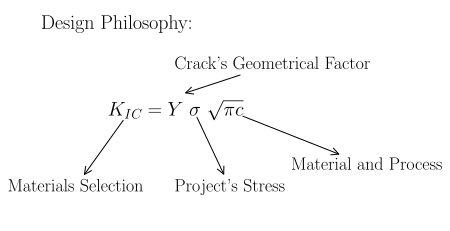

In [264]:
#HIDDEN
fig, axs = plt.subplots()
plt.text(0.1, 0.9, 'Design Philosophy:', fontsize=20)

plt.text(0.3, 0.5, '$K_{IC} = Y \ \sigma \ \sqrt{\pi c}$', fontsize=20)
plt.annotate('Materials Selection', xy=(0.35, 0.485), xytext=(0., 0.15),
             arrowprops=dict(arrowstyle='<-', linewidth=1), fontsize=18)

plt.annotate('Crack\'s Geometrical Factor', xy=(0.525, 0.6), xytext=(0.5, 0.715),
             arrowprops=dict(arrowstyle='->', linewidth=1), fontsize=18)

plt.annotate('Project\'s Stress', xy=(0.565, 0.5), xytext=(0.5, 0.15),
             arrowprops=dict(arrowstyle='<-', linewidth=1), fontsize=18)

plt.annotate('Material and Process', xy=(0.7, 0.5), xytext=(0.85, 0.25),
             arrowprops=dict(arrowstyle='<-', linewidth=1), fontsize=18)


plt.gca().axis('off')
plt.show()

As previously noted the fracture toughness, $K_{IC}$, is an intrinsic property of the material, thus it is directly correlated to the material selection. This might be limited by costs, availability and other additional necessary properties, such as low density (i.e. for transport), high operation temperature, or chemical attack resistance. The factor $Y$ comprises the geometrical factor of the crack, which will be related to the stress state, and the features of the crack. The stress, $\sigma$, is often fixed by the project and will be a constraint that must be followed. Safety factors are imposed here to guarantee that the design is safe. Finally, the critical size of the defect, $c$, is a direct consequence of the process needed to produce the material and its decrease is often limited by feasibility, cost and duration of advanced process.

As an example of applying this design philosophy, we will consider the leak before burst systems for pressurized pipes.

### Example: Leak Before Burst Systems

In a pressurized pipe the internal pressure ($P$) will yield a tensile stress, $\sigma$, as can be seen in the figure below:

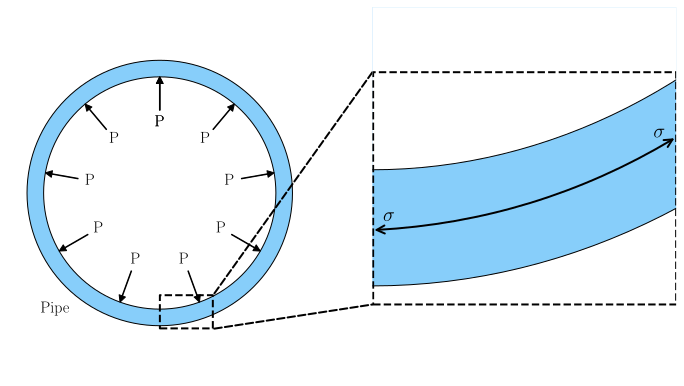

In [263]:
#HIDDEN
from matplotlib.patches import ConnectionPatch

D_ext = 0.5 # External Diameter
w_t = 0.5/8 # Wall thickness

fig, axs = plt.subplots(1, 2, figsize=(12, 6.85))

e1 = Ellipse([0.5, 0.5], D_ext, D_ext, zorder=9, fc='lightskyblue', ec='k')
axs[0].add_patch(e1)
e2 = Ellipse([0.5, 0.5], D_ext-w_t, D_ext-w_t, zorder=9, fc='w', ec='k')
axs[0].add_patch(e2)
axs[0].axis('equal')

angles = np.linspace(0, 2*np.pi, 10)
for ang in angles:
    axs[0].arrow(0.5 + D_ext/3.2*np.sin(ang), 0.5 + D_ext/3.2*np.cos(ang),
              0.05*np.sin(ang), 0.05*np.cos(ang), fc='k',
              head_width=0.0125, head_length=0.0125, zorder=10)
    axs[0].text(0.5 + D_ext/3.75*np.sin(ang), 0.4925 + D_ext/3.75*np.cos(ang),
                'P', horizontalalignment='center', zorder=11, fontsize=16)
r1 = Rectangle([0.50025, 0.245], 0.09975, 0.0625, zorder=12,
               fc="None", ls='--', ec='k', lw=2)
axs[0].add_patch(r1)
axs[0].text(0.275, 0.275, 'Pipe', c='k', zorder=11, fontsize=16)
axs[0].set_xlim(0.15, 0.85)
axs[0].set_ylim(0.15, 0.85)


r1 = Rectangle([0.50025, 0.245], 0.09975, 0.0625, zorder=12,
               fc="None", ls='--', ec='k', lw=2)
axs[1].add_patch(r1)
e1 = Ellipse([0.5, 0.5], D_ext, D_ext, zorder=9, fc='lightskyblue', ec='k')
axs[1].add_patch(e1)
e2 = Ellipse([0.5, 0.5], D_ext-w_t, D_ext-w_t, zorder=9, fc='w', ec='k')
axs[1].add_patch(e2)
style = "Simple, tail_width=0.5, head_width=4, head_length=8"
kw = dict(arrowstyle='<->, head_width=4, head_length=8', color="k", lw=2)
a3 = patches.FancyArrowPatch((0.5, 0.265), (0.6, 0.29),
                             connectionstyle="arc3,rad=0.125", zorder=10, **kw)
axs[1].add_patch(a3)
axs[1].set_xlim(0.5, 0.6)
axs[1].set_ylim(0.225, 0.325)
axs[1].text(0.5035, 0.2675, r'$\sigma$', c='k', zorder=11, fontsize=20)
axs[1].text(0.5925, 0.29, r'$\sigma$', c='k', zorder=11, fontsize=20)

kw = dict(linestyle="--", color="k", lw=2)
cp1 = ConnectionPatch((0.68, 0.23), (0, 0.825), "axes fraction", "axes fraction",
                      axesA=axs[0], axesB=axs[1], **kw)
cp2 = ConnectionPatch((0.68, 0.135), (0, 0.2), "axes fraction", "axes fraction",
                      axesA=axs[0], axesB=axs[1], **kw)
cps = [cp1, cp2]
for cp in cps:
    axs[1].add_artist(cp)


plt.axis('off')
for ax in axs.flatten():
     ax.axis('off')
#     ax.set_xticks([], [])
#     ax.set_yticks([], [])

plt.show()

For a specific case where the radius of the pipe (r) is considerably greater than the its thickness ($t$), this is stress, $\sigma$, can be found as:

\begin{equation}
\sigma = \frac{P \ r}{t}
\end{equation}

In a pipe, we could have a defect inside the wall or on its surface. As we saw earlier, surface defects are more critical than defects in the bulk of the material and consequently, as a safety measure, we will focus on a possible surface defect as shown below:

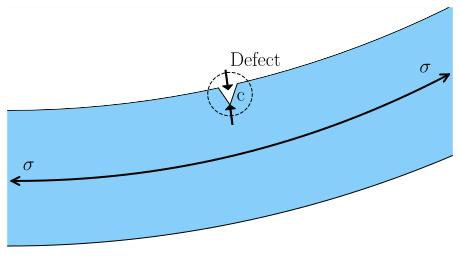

In [267]:
#HIDDEN
from matplotlib.patches import Polygon
fig, axs = plt.subplots(1, 1, figsize=(8, 8*0.6))

e1 = Ellipse([0.5, 0.5], D_ext, D_ext, zorder=10, fc='lightskyblue', ec='k')
axs.add_patch(e1)
e2 = Ellipse([0.5, 0.5], D_ext-w_t, D_ext-w_t, zorder=12, fc='w', ec='k')
axs.add_patch(e2)
e3 = Ellipse([0.5, 0.5], (D_ext-w_t)*0.999, (D_ext-w_t)*0.999, zorder=14, fc='w', ec='w')
axs.add_patch(e3)
style = "Simple, tail_width=0.5, head_width=4, head_length=8"
kw = dict(arrowstyle='<->, head_width=4, head_length=8', color="k", lw=2)
a3 = patches.FancyArrowPatch((0.5, 0.265), (0.6, 0.29),
                             connectionstyle="arc3,rad=0.125", zorder=11, **kw)
axs.add_patch(a3)
axs.add_patch(Polygon([[0.55,0.2825],[0.545,0.29],[0.5525,0.29]],
                     closed=True,fill=True, fc='w', ec='k', zorder=12)) 
e4 = Ellipse([0.55, 0.285], 0.01, 0.01, zorder=14, fc='None', ec='k', ls='--')
axs.add_patch(e4)
plt.text(0.55, 0.2915, r'Defect', c='k', zorder=15, fontsize=20)
plt.text(0.5515, 0.2835, r'c', c='k', zorder=15, fontsize=20)


plt.arrow(0.55-2*0.0005, 0.2825+2*0.004,
              +0.00045, -0.0035, fc='k', width=0.00025,
              head_width=0.00225, head_length=0.001, zorder=16)
plt.arrow(0.55+0.00055, 0.2825-0.0045,
              -0.00045, +0.0035, fc='k', width=0.00025,
              head_width=0.00225, head_length=0.001, zorder=16)
plt.xlim(0.5, 0.6)
plt.ylim(0.245, 0.305)
plt.text(0.5035, 0.2675, r'$\sigma$', c='k', zorder=11, fontsize=20)
plt.text(0.5925, 0.29, r'$\sigma$', c='k', zorder=11, fontsize=20)

plt.axis('off')
plt.grid()
plt.show()

This small crack can be originated during the processing of the pipe, during its installation, or be the result of a slow crack propagation due to fatigue or corrosion, for example. If the defect is internal, it is even harder to identify such defects.

Thus, the crack or defect might slowly achieve a critical size leading to unexpected catastrophic failure.

How can we use the design philosophy to create a system that "fails safe"?

Let's consider the following widget. We have our blue pipe with a specific thickness $t$. For a given material and internal pressure we can calculate the critical size of defect. On the right side, we plot the pairs failure stress-defect size and see the effect of using different values of thickness.

In [273]:
#HIDDEN
def see_pipe(w_t):
    D_ext = 0.5 # External Diameter
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    e1 = Ellipse([0.5, 0.5], D_ext/2, D_ext/2, zorder=9, fc='lightskyblue', ls='--', ec='k')
    axs[0].add_patch(e1)
    e2 = Ellipse([0.5, 0.5], D_ext/2-2*w_t, D_ext/2-2*w_t, zorder=9, fc='w', ec='k')
    axs[0].add_patch(e2)
    e3 = Ellipse([0.5, 0.5], D_ext/2-0.5/8, D_ext/2-0.5/8, zorder=9, ls='--', fc='none', ec='k')
    axs[0].add_patch(e3)
    e4 = Ellipse([0.5, 0.5], D_ext/2, D_ext/2, zorder=9, fc='gold', alpha=0.5, ec='k')
#     axs.add_patch(e4)
    axs[0].axis('equal')
    axs[0].arrow(D_ext, 0.5+0.125-0.0625/2,
              0, +0.0625/2*0.925, fc='k', width=0.00025,
              head_width=0.0025, head_length=0.002, zorder=16)
    axs[0].arrow(D_ext, 0.5+0.125,
              0, -0.0625/2*0.925, fc='k', width=0.00025,
              head_width=0.0025, head_length=0.002, zorder=16)
    axs[0].text(D_ext+0.005, 0.5+0.125-0.0625/4-0.005, r'$c^*$', zorder=16, fontsize=18)
    axs[0].axis('off')
    K_Ic_2 = 10
    sigma_f = lambda K_Ic, c: K_Ic/(np.pi*c)**0.5
    cs = np.linspace(0.5/32, 0.5/7, 100)
    axs[1].plot(cs, sigma_f(K_Ic_2, cs), '-o', markevery=6,  c='orangered', zorder=5)
    axs[1].scatter([w_t], [sigma_f(K_Ic_2, w_t)], marker='x', color='k', zorder=20)
#     axs[1].text(0.8, 4.75, r'Material 2', fontsize=16, c='orangered')
    axs[1].axvline(w_t, c='blue', lw=2, ymax=0.85, zorder=17)
    axs[1].axis('off')
    axs[1].set(xlim=(0, 0.075), ylim=(20, 50))
    axs[1].arrow(0, 20.75, 0.0735, 0, head_width=0.5, head_length=0.0015, fc='k')
    axs[1].arrow(0.001, 20.5, 0, 26, width=0.00001, head_width=0.00125, head_length=0.75, fc='k')
    axs[1].text(0.0575, 24, r'$\sigma_f = \frac{K_{IC}}{\sqrt{\pi c}}$', fontsize=18)
    axs[1].axhline(K_Ic_2/(np.pi*0.5/16)**0.5, c='k', ls='--')
    axs[1].text(-0.005, K_Ic_2/(np.pi*0.5/16)**0.5, r'$\sigma_y$', fontsize=18)
    r1 = Rectangle([0.001, 20.75], 0.0735, K_Ic_2/(np.pi*0.5/16)**0.5-20-0.75,
                   zorder=9, alpha=0.25, fc='red', ls='--', ec='k')
    axs[1].add_patch(r1)
    axs[1].text(0.0025, 22, r'Failure Before Yield', fontsize=14)
    r2 = Rectangle([0.001, K_Ic_2/(np.pi*0.5/16)**0.5], 0.0735, 15,
                   zorder=9, alpha=0.25, fc='green', ls='--', ec='k')
    axs[1].add_patch(r2)
    axs[1].text(0.0475, 45, r'Failure After Yield', fontsize=14)
    axs[1].text(w_t, 18.5, r'$t$', fontsize=14)
    axs[1].text(0.5/16, 19.5, r'$c^*$', fontsize=14)
    plt.plot([0.5/16, 0.5/16], [20.5, 21], c='k', zorder=17)
    axs[1].text(-0.005, 47, r'$\sigma_f$', fontsize=18)
    axs[1].text(0.07, 19.5, r'$c$', fontsize=18)
    plt.show()
interactive_plot = interactive(see_pipe, w_t=widgets.FloatSlider(value=0.5/16,
                                                       min=0.5/32,
                                                       max=0.5/8,
                                                       step=0.5/64,
                                                       description='$t$',
                                                       readout_format='.4e'))
output = interactive_plot.children[-1]
output.layout.height = '550px'
interactive_plot.layout = widgets.Layout(display='flex',
                               flex_flow='column',
                               align_items='center',
                               align_content='center',
                               justify_content='center',
                               width='100%')
interactive_plot

interactive(children=(FloatSlider(value=0.03125, description='$t$', max=0.0625, min=0.015625, readout_format='…

If we use values of thickness higher than $c^*$ we can have the catastrophic failure scenario. If, however, we decrease the thickness to values lower than the critical defect size, we can find that the failure will occur after yielding, in a not catastrophic way, being able to easily identify and repair before daunting consequences.

# References

[1] <a href="https://yenaengineering.nl/ductile-brittle-transition-temperature-and-impact-energy-tests/" target="_blank" rel="noopener noreferrer">Yena Engineering, Ductile-Brittle Transition Temperature and Impact Energy Tests.</a> <a id="cit-ref_db_trans" href="#call-ref_db_trans">[↩]</a>

[2] <a href="https://www.researchgate.net/publication/258004229_In-situ_experimental_study_of_the_seismic_signatures_of_the_role_of_fluids_in_the_rupture_of_fault_zones_Application_to_large_rockslides_failure_studies/figures?lo=1&utm_source=bing&utm_medium=organic" target="_blank" rel="noopener noreferrer">Deroide B., In-situ experimental study of the seismic signatures of the role of fluids in the rupture of fault zones: Application to large rockslides failure studies.</a> <a id="cit-ref_modes" href="#call-ref_mode">[↩]</a>

[3] <a href="https://commons.wikimedia.org/wiki/File:Fracture_toughness_vs._Strength.jpg" target="_blank" rel="noopener noreferrer">Wikimedia Commons, the free media repository, Fracture toughness vs. Strength.</a> <a id="cit-ref_ashby" href="#call-ref_ashby">[↩]</a>

[4] <a href="https://www.mdpi.com/2624-5558/1/2/14" target="_blank" rel="noopener noreferrer">Taheri et al., Corrosion Inhibitory Effects of Mullite in Concrete Exposed to Sulfuric Acid Attack.</a> <a id="cit-ref_micro" href="#call-ref_micro">[↩]</a>

[5] <a href="https://www.matec-conferences.org/articles/matecconf/abs/2014/02/matecconf_cmss2013_03012/matecconf_cmss2013_03012.html" target="_blank" rel="noopener noreferrer">Abdelgader et al., Concreting Method that Produce High Modulus of Elasticity.</a> <a id="cit-ref_cs" href="#call-ref_cs">[↩]</a>

[6] <a href="https://www.cambridge.org/core/books/fracture-of-brittle-solids/B1EC1413BDBA1DCF49E1665D4B0A20F3" target="_blank" rel="noopener noreferrer">Lawn B., Fracture of Brittle Solids. Page 46</a> <a id="cit-ref_book" href="#call-ref_book">[↩]</a>

[7] <a href="https://www.911metallurgist.com/blog/wp-content/uploads/2016/02/ball-mill-animation.gif" target="_blank" rel="noopener noreferrer">Ball milling animation.</a> <a id="cit-ref_bml" href="#call-ref_bml">[↩]</a>